<a href="https://colab.research.google.com/github/abaskon/Particle_Filter_Localisation/blob/main/AMCL_DR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = (15,8)
mpl.rcParams['axes.grid'] =True
  

In [2]:
!git clone https://github.com/abaskon/Particle_Filter_Localisation.git

fatal: destination path 'Particle_Filter_Localisation' already exists and is not an empty directory.


In [3]:
amcl = pd.read_csv('https://raw.githubusercontent.com/abaskon/Particle_Filter_Localisation/main/CSV/amcl_pose.csv')
odom_f =  pd.read_csv('https://raw.githubusercontent.com/abaskon/Particle_Filter_Localisation/main/CSV/odometry-filtered.csv') 
odom =  pd.read_csv('https://raw.githubusercontent.com/abaskon/Particle_Filter_Localisation/main/CSV/odom.csv')
tf =  pd.read_csv('https://raw.githubusercontent.com/abaskon/Particle_Filter_Localisation/main/CSV/tf.csv')
clock =  pd.read_csv('https://raw.githubusercontent.com/abaskon/Particle_Filter_Localisation/main/CSV/clock.csv')

In [4]:
amcl.head()

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,pose.pose.position.x,pose.pose.position.y,pose.pose.position.z,pose.pose.orientation.x,pose.pose.orientation.y,pose.pose.orientation.z,pose.pose.orientation.w,pose.covariance
0,34.674,0,10,397000000,map,0.012766,-0.001858,0.0,0.0,0.0,0.000086,1.000000,"(0.2470653041573616, 0.0019165315976033225, 0...."
1,56.439,1,56,398000000,map,0.248594,0.094097,0.0,0.0,0.0,0.178186,0.983997,"(0.18950598300327587, -0.005191661325132511, 0..."
2,61.427,2,61,398000000,map,0.610166,0.239486,0.0,0.0,0.0,0.177205,0.984174,"(0.15812233142807763, -0.0028520728322717626, ..."
3,65.827,3,65,798000000,map,1.010377,0.289293,0.0,0.0,0.0,0.020810,0.999783,"(0.12805022456698278, 0.0017301901724648405, 0..."
4,70.021,4,69,998000000,map,1.420104,0.292532,0.0,0.0,0.0,0.022802,0.999740,"(0.10035431183717636, 0.0005044863828376212, 0..."


In [5]:
pip install squaternion 

In [6]:
from squaternion import Quaternion

In [7]:

def find_theta(data):
  data['theta']=0
  for i in range (0,len(data)):
    quaternion = Quaternion(data["pose.pose.orientation.x"][i],data["pose.pose.orientation.y"][i],data["pose.pose.orientation.z"][i],data["pose.pose.orientation.w"][i])
    data['theta'][i] = data['theta'][i]+ quaternion.to_euler(degrees=True)[0]
  

In [8]:
amcl_position = amcl.pivot("pose.pose.position.x","pose.pose.position.y")

In [9]:
import pandas as pd
from pandas_datareader import data
import seaborn as sns
import io
sns.set(style="darkgrid")

In [ ]:
tf.head()

In [ ]:
print(tf.transforms[0])

# Strips the newline character

tf['pose.pose.position.x'] = 0.0
tf['pose.pose.position.y'] = 0.0
tf['pose.pose.orientation.x'] =0.0
tf['pose.pose.orientation.y'] =0.0
tf['pose.pose.orientation.z'] =0.0
tf['pose.pose.orientation.w'] =0.0

for i in range (0,len(tf)):
  buf = io.StringIO(tf.transforms[i])
  Lines = buf.readlines()
  tf['pose.pose.position.x'][i] = float(Lines[9].strip()[3:15])
  tf['pose.pose.position.y'][i] = float(Lines[10].strip()[3:15])
  tf['pose.pose.orientation.x'][i] = float(Lines[13].strip()[3:15])
  tf['pose.pose.orientation.x'][i]= float(Lines[14].strip()[3:15])
  tf['pose.pose.orientation.x'][i] = float(Lines[15].strip()[3:15])
  tf['pose.pose.orientation.x'][i] = float(Lines[15].strip()[3:15])

In [ ]:
find_theta(amcl)
find_theta(odom_f)
find_theta(tf)

In [ ]:
tf[50:]

No handles with labels found to put in legend.


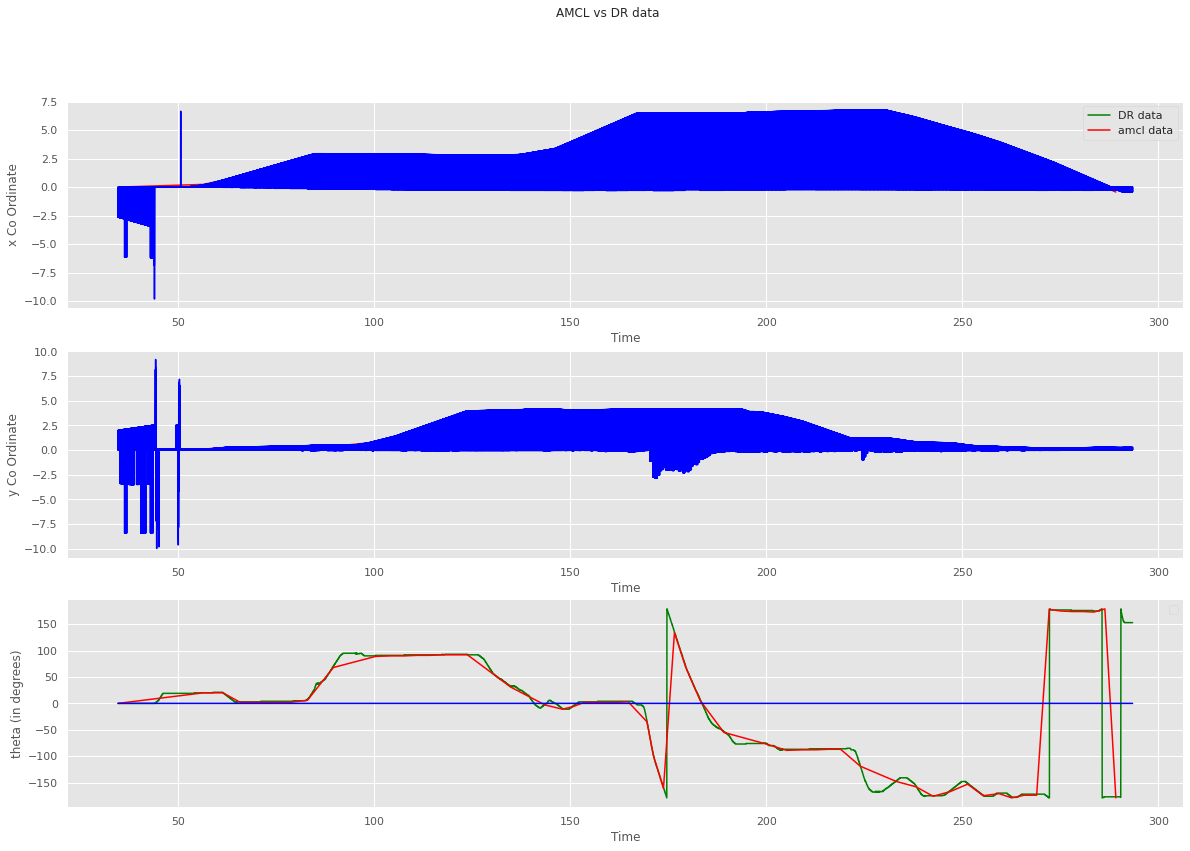

In [21]:
plt.style.use('ggplot')

fig, ax = plt.subplots(3)
fig.suptitle('AMCL vs DR data')
# Plot 0
ax[0].plot(odom_f.Time, odom_f["pose.pose.position.x"], color="green")
ax[0].plot(amcl.Time, amcl["pose.pose.position.x"], color="red")
ax[0].plot(tf.Time, tf["pose.pose.position.x"], color="blue")

ax[0].set(xlabel='Time', ylabel='x Co Ordinate')
ax[0].legend(["DR data", "amcl data"], loc ="upper right")

# Plot 1
ax[1].plot(odom_f.Time, odom_f["pose.pose.position.y"], color="green")
ax[1].plot(amcl.Time, amcl["pose.pose.position.y"], color="red")
ax[1].set(xlabel='Time', ylabel='y Co Ordinate')
ax[1].plot(tf.Time, tf["pose.pose.position.y"], color="blue")

# Plot 2
ax[2].plot(odom_f.Time, odom_f["theta"], color="green")
ax[2].plot(amcl.Time, amcl["theta"], color="red")
ax[2].set(xlabel='Time', ylabel='theta (in degrees)')
ax[2].plot(tf.Time, tf["theta"], color="blue")

# show legend
plt.legend()
plt.rcParams['figure.figsize'] = [20, 13]
# show graph
plt.show()